# Hyperparameter tunning 

In [ ]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from collections import Counter
import pandas as pd
import numpy as np
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sea
import logging
logging.basicConfig(filename="debug_genic.log", level=logging.INFO)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

plant_dir = os.environ.get("PLANT_DIR")
if not plant_dir:
    raise EnvironmentError("PLANT_DIR environment variable is not set")

OUTPUT_DIR_NAME = os.path.join(plant_dir, \
                                "experimental_setup",\
                                "models", \
                                "models_genic_a_thaliana")

DATASET_NAME = os.path.join(plant_dir, \
                            "experimental_setup", \
                            "datasets", \
                            "dataset_a_thaliana", \
                            "final", \
                            "dataset_a_thaliana_1500_50.csv")

os.makedirs(OUTPUT_DIR_NAME, exist_ok=True)

def import_data_everything(dataset=DATASET_NAME):
    data = pd.read_csv(dataset)
    logging.info(f"Read CSV: {data.shape}")

    data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    logging.info(f"After shuffle: {data.shape}")

    data = data.drop(columns=["species"])

    data = data.dropna()
    logging.info(f"After dropna: {data.shape}")

    print("Original size:", len(data))
    logging.info(f"Original size: {len(data)}")

    plt.figure(figsize=(6, 6)) 
    sea.countplot(x="label", hue="label", data=data, palette="Set3", legend=False)

    plt.title("Before filtering", fontsize=12)
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()
    
    return data

    
def import_split_scale_data(dataset):
    le = LabelEncoder()

    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    features = dataset.drop(columns=["label"])
    dataset["_features_tuple"] = features.apply(lambda row: tuple(row), axis=1)
    dataset = dataset.drop_duplicates(subset="_features_tuple", keep="first")
    dataset = dataset.drop(columns=["_features_tuple"])

    dataset["label"] = le.fit_transform(dataset["label"])

    X = dataset.drop(['label'], axis=1)
    y = dataset['label'].values

    features_names = X.columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, le, features_names


def undersample_data(X_train, y_train):
    rs = RandomUnderSampler(random_state=42)
    X_train, y_train = rs.fit_resample(X_train, y_train)

    print('Resampled dataset shape %s' % Counter(y_train))
    logging.info('Resampled dataset shape %s' % Counter(y_train))

    return X_train, y_train

def oversample_data(X_train, y_train):
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    print('Resampled dataset shape %s' % Counter(y_train))
    logging.info('Resampled dataset shape %s' % Counter(y_train))

    return X_train, y_train

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import joblib

def tune_and_evaluate(name, model, params, sampling, X_train, y_train, X_test, y_test, le, y_test_bin, feature_names):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])

    grid = RandomizedSearchCV(pipe, params, n_iter=10, cv=3, n_jobs=4, random_state=42)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    print(f"Best params: {grid.best_params_}")

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    y_pred_bin = label_binarize(y_pred, classes=list(range(len(le.classes_))))

    auc_roc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
    auc_pr = average_precision_score(y_test_bin, y_pred_bin, average="macro")

    result = {
        "Model": name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"],
        "AUC-ROC": auc_roc,
        "AUC-PRC": auc_pr
    }

    joblib.dump({
        "pipeline": best_model,
        "label_encoder": le,
        "results": result,
        "feature_names": feature_names
    }, f"{OUTPUT_DIR_NAME}/model_{sampling}_{name.replace(' ', '_')}_50.pkl")

    return result, best_model

    
def import_results(name, sampling):
    with open(f"{OUTPUT_DIR_NAME}/model_{sampling}_{name}_50.pkl", "rb") as f:
        RF = joblib.load(f)
    return RF

Original size: 856050


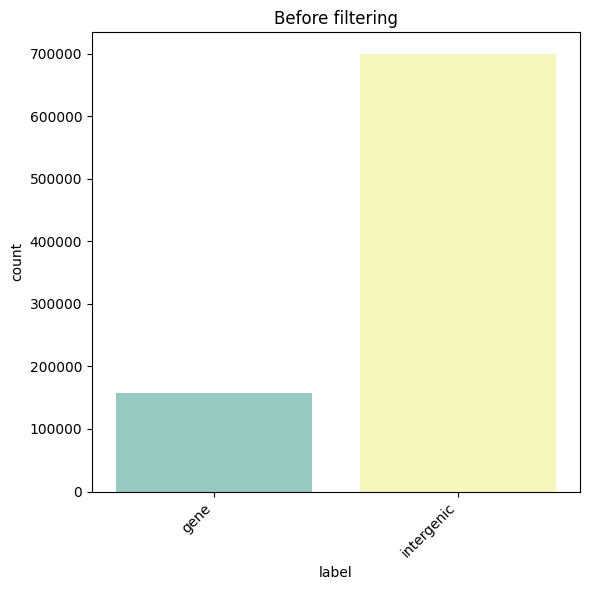

In [3]:
data = import_data_everything()
X_train, X_test, y_train, y_test, le, features_names = import_split_scale_data(data)
y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_))))

In [5]:
tasks = [
    ("Random_Forest", RandomForestClassifier(random_state=42, n_jobs=4), {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__max_features': ['sqrt', 'log2']
    }),
    ("XGBoost", XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=4), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.7, 0.8, 1.0],
        'clf__colsample_bytree': [0.7, 0.8, 1.0]
    })
]

## Undersampling

In [ ]:
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train)

Resampled dataset shape Counter({0: 109848, 1: 109848})


In [9]:
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [
        executor.submit(
            tune_and_evaluate, 
            name, model, params, "undersampling", 
            X_train_undersampled, y_train_undersampled, X_test, y_test, le, y_test_bin, features_names
        ) for name, model, params in tasks
    ]
    results_models = [future.result() for future in futures]

results = []

/home/bruna.simoes/test_model/testing_ML/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__subsample': 0.7, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.2, 'clf__colsample_bytree': 0.7}


Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


In [10]:
RF = import_results("Random_Forest", "undersampling")
XGB = import_results("XGBoost", "undersampling")

results.append(RF["results"])
results.append(XGB["results"])

In [11]:
df_results = pd.DataFrame(results)

print(df_results)

           Model  Precision    Recall  F1-score   AUC-ROC   AUC-PRC
0  Random_Forest   0.971304  0.968305  0.969025  0.971863  0.988772
1        XGBoost   0.973172  0.970659  0.971268  0.973461  0.989374
